In [1]:
import lightgbm as lgbm
from hyperopt import hp, tpe, Trials

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import feature_importances,initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score,feature_imp_lgbm
import pickle

from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve


In [3]:
prepos= preprocessing()
df_credit_application = prepos.read_data("credit_applications.csv")
df_customers = prepos.read_data("customers.csv")
df_customers.drop("Unnamed: 0",axis=1,inplace=True)
df_credit_application.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
df_complete_data = df_customers.merge(df_credit_application,how="inner",on=["client_nr","yearmonth"])
df_complete_data.drop("nr_credit_applications",axis=1,inplace=True)
df_complete_data[df_complete_data["CRG"].isna()]["credit_application"].value_counts()
print(df_complete_data.shape)

(29996, 11)


##### EDA And feature importances

In [5]:
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application
count,29996.000000,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000
mean,481.560775,201493.675157,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509
std,281.317753,77.361645,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000
25%,237.000000,201409.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000
50%,479.000000,201505.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000
75%,721.000000,201601.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000
max,1000.000000,201608.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000


<Axes: xlabel='credit_application', ylabel='count'>

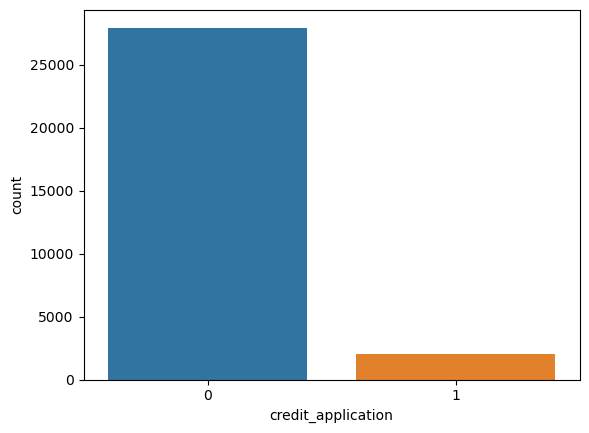

In [6]:
sns.countplot(x=df_complete_data["credit_application"])

# 0    27971
# 1     2025

In [7]:
prepos.missing_values_intable(df_complete_data)

,Missing Values,Percentage of missing values
client_nr,0,0.000000
yearmonth,0,0.000000
total_nr_trx,0,0.000000
nr_debit_trx,0,0.000000
volume_debit_trx,0,0.000000
nr_credit_trx,0,0.000000
volume_credit_trx,0,0.000000
min_balance,0,0.000000
max_balance,0,0.000000
CRG,5537,18.459128


In [8]:
# plt.rcParams["figure.figsize"] = [5,5]  #set the graph to a smaller size 
df_complete_data["debit_credit_ratio"]=df_complete_data["volume_debit_trx"]/df_complete_data["volume_credit_trx"]

In [9]:
df_complete_data["debit_credit_ratio"] = np.where(df_complete_data["debit_credit_ratio"]==np.inf,df_complete_data["volume_debit_trx"],df_complete_data["debit_credit_ratio"])

In [10]:
corl= df_complete_data.corr()
corl["credit_application"].sort_values(ascending=False)

credit_application    1.000000
CRG                   0.104958
nr_debit_trx          0.030467
client_nr             0.020659
volume_credit_trx     0.013168
volume_debit_trx      0.008674
total_nr_trx         -0.001848
debit_credit_ratio   -0.002477
yearmonth            -0.011546
nr_credit_trx        -0.011643
max_balance          -0.043633
min_balance          -0.082577
Name: credit_application, dtype: float64

In [11]:

fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

Removing columns: []
['min_balance', 'CRG', 'credit_application']
credit_application    1.00
CRG                   0.13
min_balance           0.08
max_balance           0.04
nr_debit_trx          0.03
client_nr             0.02
yearmonth             0.01
volume_debit_trx      0.01
nr_credit_trx         0.01
volume_credit_trx     0.01
total_nr_trx          0.00
debit_credit_ratio    0.00
Name: credit_application, dtype: float64


For a Time being delete rows where CRG is not present

In [12]:
# df_complete_data[df_complete_data["CRG"].isna()]["credit_application"].value_counts()
# 0    5395
# 1     142

In [13]:
df_complete_data = df_complete_data[~df_complete_data["CRG"].isna()]

In [14]:
df_complete_data.shape

(24459, 12)

#### To do : Missing value treatment for CRG

In [15]:
df_complete_data.groupby(["client_nr","yearmonth","CRG"])["total_nr_trx"].count().reset_index()

,client_nr,yearmonth,CRG,total_nr_trx
0,1,201401,1.0,1
1,1,201402,1.0,1
2,1,201403,1.0,1
3,1,201404,1.0,1
4,1,201405,1.0,1
...,...,...,...,...
24454,988,201604,3.0,1
24455,988,201605,3.0,1
24456,988,201606,3.0,1
24457,988,201607,3.0,1


###### New features ideas
Calculate how many times client has applied for credit in the past for each month

In [16]:
def calculate_nr_credit_in_past(current_index):
#     print(current_index)
    client_nr = df_complete_data.loc[[current_index]]["client_nr"].values[0]
    tmp_sum = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].sum()
    tmp_cnt = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].count()
    if(tmp_cnt==0):
        return 0
    else:
        return tmp_sum/tmp_cnt
    
    


In [17]:
df_complete_data["credit_applied_before_ratio"]= df_complete_data.index.map(calculate_nr_credit_in_past)

 ###### Is_debit_more_average
 
 Is volume_debit_trx is more than the average of the volume_debit_trx for that client
 If yes 1 else 0

In [18]:
# debit_average_per_client = df_complete_data.groupby(["client_nr"]).mean()["volume_debit_trx"].reset_index()
# df_complete_data["debit_average_per_client"] = df_complete_data["client_nr"].apply(lambda x: debit_average_per_client[debit_average_per_client["client_nr"]==x]["volume_debit_trx"].values[0])
# df_complete_data["Is_debit_more_average"]=np.where(df_complete_data["debit_average_per_client"] < df_complete_data["volume_debit_trx"],1,0)
# df_complete_data.drop(["debit_average_per_client"],axis=1,inplace=True)

#### Split data strategy

As part of train/test data split, 20% of data will be reserved as test data and will not seen by any model.
That amounts to approximately = 6 months worth of data.
Instead of splitting train/test data randomly, I decided to leave last 6 month data as test data set i.e. March 2016 to August 2016

In [19]:
def Split_data(df_complete_data):
    X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
    y_test = X_test["credit_application"]

    X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
    y_train_org = X_train_org["credit_application"]

    X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

    X_test.drop(["credit_application"],axis=1,inplace=True)
    X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
    X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
    X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)
    
    return X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val
    

In [24]:
X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val=Split_data(df_complete_data)

In [20]:
# X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
# y_test = X_test["credit_application"]

# X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
# y_train_org = X_train_org["credit_application"]

# X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

# X_test.drop(["credit_application"],axis=1,inplace=True)
# X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
# X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
# X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)


# X_test.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train_org.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_val.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)

##### 2. Using Lightgbm feature importance

In [21]:

params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }


In [22]:
# params_scope = {
# #                 'learning_rate': [x/1000 for x in range(1, 110,10)],
#                 'n_estimators': [x for x in range(10, 500,50)],
#                'num_leaves': [x for x in range(2, 15,2)],
#                'scale_pos_weight':[x for x in range(85, 100,5)],
#                'objective': ['binary'],
# #                'reg_lambda ': [x for x in range(10, 100,10)],
#                }

# import lightgbm as lgb
# model = lgb.LGBMClassifier(**params_scope)
# grid = GridSearchCV(model, param_grid=params_scope, verbose=1, cv=3, n_jobs=-1)
# # Run the grid
# grid.fit(X_train,y_train)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)
# model = grid.best_estimator_
# feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
#                    'feature_importance':model.feature_importances_},
            
#             )
# feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

In [25]:
model,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
                   'feature_importance':model.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|███████████████████████████████████████████████| 250/250 [04:59<00:00,  1.20s/trial, best loss: 0.747870528109029]


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [26]:
print(initial_params)
feature_imp_df

{'learning_rate': 0.004585134944970317, 'max_bin': 192.0, 'n_estimators': 290.0, 'num_leaves': 11.0, 'pos_bagging_fraction': 0.44541893337068433, 'reg_lambda': 59.203431465570176, 'scale_pos_weight': 15.0}


,feature_name,feature_importance
6,min_balance,471
8,CRG,459
10,credit_applied_before_ratio,363
2,nr_debit_trx,337
9,debit_credit_ratio,269
0,yearmonth,244
7,max_balance,201
1,total_nr_trx,151
4,nr_credit_trx,150
3,volume_debit_trx,139


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


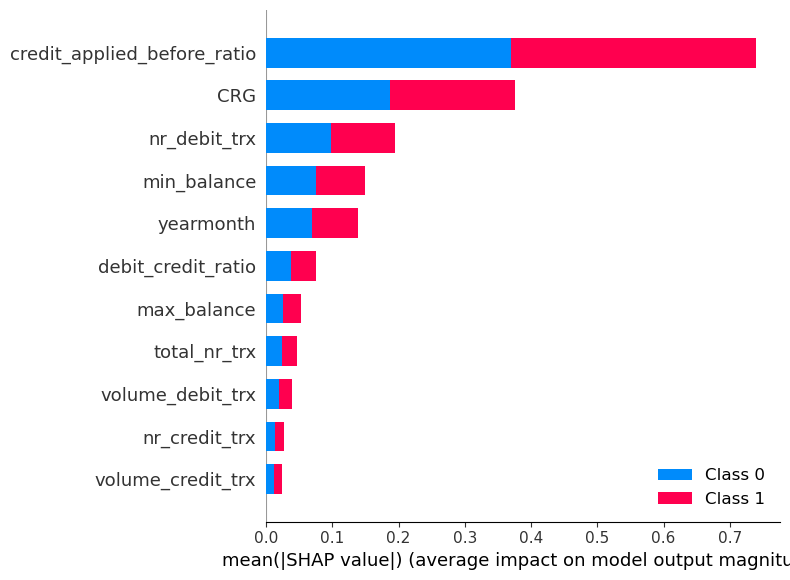

In [27]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")

In [28]:

def cross_validation(model,X_train_org,y_train_org,threshold):
    
    kfolds = StratifiedKFold(5)
    current_f1_scores=[]
    roc_auc_scores_val=[]
    precision_score_val=[]
    recall_score_val=[]
    fpr_scores=[]
    tpr_scores=[]

    
    
    for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
        model.fit(
                    X_train_org.iloc[train_idx],
                    y_train_org.iloc[train_idx]
#                   ,eval_metric=lgb_f1_score
                )
        y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >threshold,1,0)
        current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
        tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
        print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
        print(y_pred)
        roc_auc_scores_val.append(roc_auc_score(y_train_org.iloc[val_index], y_pred))
        precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
        fpr_scores.append(fpr_val)
        tpr_scores.append(tpr_val)
    
    return current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores

    

def plot_roc(fpr,tpr,roc_auc,color_ip):
    print('ROC AUC=%0.2f'%roc_auc)
    plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc,color=color_ip)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
#     plt.show()

In [29]:
current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model,X_train_org,y_train_org,0.4)

[[2179 1489]
 [  79  233]]
[0 0 0 ... 1 0 1]
[[2049 1618]
 [  90  222]]
[0 0 0 ... 0 1 1]
[[2093 1574]
 [  79  233]]
[0 0 0 ... 0 1 1]
[[1581 2086]
 [  70  242]]
[1 1 1 ... 1 1 0]
[[1605 2062]
 [  52  260]]
[0 0 0 ... 0 0 0]


ROC AUC=0.67
ROC AUC=0.64
ROC AUC=0.66
ROC AUC=0.60
ROC AUC=0.64
Mean ROC AUC score on validation data =0.64


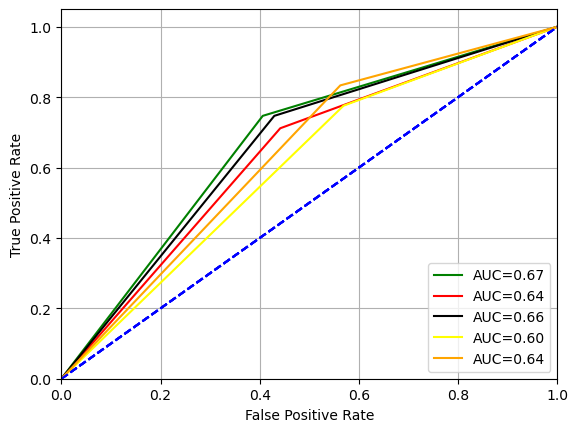

In [30]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [31]:
def print_metrics(f1_scores,recall_scores,precision_scores,dataset="validation"):
    print("F1 scores on "+ dataset+" data:")
    print(f1_scores)
    print("-----------------------------------------------------")
    print("Recall scores on "+ dataset+" data:")
    print(recall_scores)
    print("-----------------------------------------------------")
    print("Mean f1 score on "+ dataset+" data:")
    print(np.mean(f1_scores))

    print("-----------------------------------------------------")
    print("Mean recall score on "+ dataset+" data:")
    print(np.mean(recall_scores))

    print("-----------------------------------------------------")
    print("Mean precision score on "+ dataset+" data:")
    print(np.mean(precision_scores))

In [32]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22910521140609635, 0.20631970260223048, 0.21991505427088248, 0.18333333333333335, 0.19741837509491267]
-----------------------------------------------------
Recall scores on validation data:
[0.7467948717948718, 0.7115384615384616, 0.7467948717948718, 0.7756410256410257, 0.8333333333333334]
-----------------------------------------------------
Mean f1 score on validation data:
0.20721833534149106
-----------------------------------------------------
Mean recall score on validation data:
0.7628205128205129
-----------------------------------------------------
Mean precision score on validation data:
0.12016545651941649


###### On test data

In [33]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1854 2386]
 [  40  283]]
F1 score on Test data:
0.1891711229946524
-----------------------------------------------------
Recall score on Test data:
0.8761609907120743
-----------------------------------------------------
Precision score on Test data:
0.10603222180591983
---------------THRESHOLD =0.35 ----------------------
[[2097 2143]
 [  52  271]]
F1 score on Test data:
0.19802703690171722
-----------------------------------------------------
Recall score on Test data:
0.8390092879256966
-----------------------------------------------------
Precision score on Test data:
0.11226180613090307
---------------THRESHOLD =0.4 ----------------------
[[2213 2027]
 [  59  264]]
F1 score on Test data:
0.2019892884468248
-----------------------------------------------------
Recall score on Test data:
0.8173374613003096
-----------------------------------------------------
Precision score on Test data:
0.1152335224792667
---------------THRESH

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [35]:
# X_test=X_test[X_train.columns]
y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >0.45,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2304 1936]
 [  69  254]]
F1 score on Test data:
0.20214882610425788
-----------------------------------------------------
Recall score on Test data:
0.7863777089783281
-----------------------------------------------------
Precision score on Test data:
0.11598173515981736


In [83]:
### Save preds to csv file

# X_test["ground_truth"] = y_test
# X_test["pred_lgbm"]=y_test_pred
# X_test.to_csv("output files/predictions_on_test_set_lgbm.csv")
pickle.dump(model,open('output files/model_lgbm.pkl','wb'))


###### SVM 

In [ ]:
# from sklearn.preprocessing import StandardScaler,MinMaxScaler
# std=StandardScaler()
# Xformed_data = std.fit_transform(X_train_org)
# Xformed_data = pd.DataFrame(Xformed_data,columns=X_train_org.columns)
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC
# def svm_hyper(X_train_transformed, y_train):
#     svc = SVC()
#     C_range = [0.001,0.1,1,10]
# #     gamma_range = [0.001,0.1,1,'scale', 'auto']    
#     param_grid = { 
#         "C": C_range,
#         "kernel": ['rbf', 'poly']
# #         ,"gamma": gamma_range
#         }
#     print(param_grid)
#     scoring = ['f1']
# #     kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
#     random_search = RandomizedSearchCV(estimator=svc, 
#                                param_distributions=param_grid, 
#                                n_iter=5,
#                                scoring=scoring,
#                                refit="f1",        
#                                n_jobs=-1, 
#                                cv=3)
#     # Fit grid search
#     random_result = random_search.fit(X_train_transformed, y_train)
#     # Print grid search summary
#     model = random_search.best_estimator_
#     return model,random_search

# model,random_search = svm_hyper(Xformed_data,y_train_org)
# import pickle
# # pickle.dump(model,open("output files/model_svm.pkl","wb"))
# model_svm = pickle.load(open("output files/model_svm.pkl","rb"))
# y_test_pred = model_svm.predict(X_test[X_train.columns])
# print(confusion_matrix(y_test_pred,y_test))
# print(f1_score(y_test_pred,y_test))


###### Random forest 

In [42]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score,RandomizedSearchCV


In [43]:
# from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10],
 'bootstrap': [True, False]}

In [44]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_rf = BalancedRandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train_org, y_train_org)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [47]:
rf_random.best_estimator_

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=10,
                               min_samples_split=5, n_estimators=700)

In [45]:
model_rf=rf_random.best_estimator_

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
        
    current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model_rf,X_train_org,y_train_org,0.45)

[[2025 1643]
 [  70  242]]
[0 0 0 ... 0 0 1]


TypeError: 'numpy.float64' object is not callable

In [ ]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [48]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22910521140609635, 0.20631970260223048, 0.21991505427088248, 0.18333333333333335, 0.19741837509491267]
-----------------------------------------------------
Recall scores on validation data:
[0.7467948717948718, 0.7115384615384616, 0.7467948717948718, 0.7756410256410257, 0.8333333333333334]
-----------------------------------------------------
Mean f1 score on validation data:
0.20721833534149106
-----------------------------------------------------
Mean recall score on validation data:
0.7628205128205129
-----------------------------------------------------
Mean precision score on validation data:
0.12016545651941649


In [49]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1395 2845]
 [  25  298]]
F1 score on Test data:
0.17195614541257934
-----------------------------------------------------
Recall score on Test data:
0.9226006191950464
-----------------------------------------------------
Precision score on Test data:
0.09481387209672287
---------------THRESHOLD =0.35 ----------------------
[[1788 2452]
 [  35  288]]
F1 score on Test data:
0.18805093046033303
-----------------------------------------------------
Recall score on Test data:
0.891640866873065
-----------------------------------------------------
Precision score on Test data:
0.10510948905109489
---------------THRESHOLD =0.4 ----------------------
[[2031 2209]
 [  51  272]]
F1 score on Test data:
0.1940085592011412
-----------------------------------------------------
Recall score on Test data:
0.8421052631578947
-----------------------------------------------------
Precision score on Test data:
0.10963321241434905
---------------THRES

In [51]:

y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >0.45,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2378 1862]
 [  66  257]]
F1 score on Test data:
0.21048321048321048
-----------------------------------------------------
Recall score on Test data:
0.7956656346749226
-----------------------------------------------------
Precision score on Test data:
0.12128362435110901


In [62]:
### Save preds to csv file

# X_test["ground_truth"] = y_test
# X_test["pred_rf"]=y_test_pred
# X_test.to_csv("output files/predictions_on_test_set_rf_threshold_0.5.csv")


pickle.dump(model,open("output files/model_rf.pkl","wb"))

##### Unsupervised (Isolation forest)

In [53]:

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,recall_score,precision_score

In [54]:
model_iso = IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,n_estimators=230)
model_iso.fit(X_train_org)

X does not have valid feature names, but IsolationForest was fitted with feature names


IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,
                n_estimators=230)

In [55]:
model_iso.predict(X_test[X_train.columns])
y_test_pred = model_iso.predict(X_test[X_train.columns])
y_test_pred = [1 if x==-1 else 0 for x in y_test_pred ]
score = f1_score(y_test, y_test_pred)

In [56]:
print(score)
print(recall_score(y_test, y_test_pred))

0.10701107011070111
0.08978328173374613


In [57]:
X_test["iso_pred"]=y_test_pred

##### Ensemble voting

In [58]:
X_test["final_pred"]=np.where(X_test["pred_lgbm"]+X_test["pred_rf"]+X_test["iso_pred"]>1,1,0)

In [59]:
print(f1_score(X_test["ground_truth"],X_test["final_pred"]))
print(recall_score(X_test["ground_truth"],X_test["final_pred"]))
print(precision_score(X_test["ground_truth"],X_test["final_pred"]))
confusion_matrix(X_test["ground_truth"],X_test["final_pred"])

0.2145054945054945
0.7554179566563467
0.125


array([[2532, 1708],
       [  79,  244]], dtype=int64)

In [60]:
print(f1_score(X_test["ground_truth"],X_test["pred_lgbm"]))
print(recall_score(X_test["ground_truth"],X_test["pred_lgbm"]))
print(precision_score(X_test["ground_truth"],X_test["pred_lgbm"]))
confusion_matrix(X_test["ground_truth"],X_test["pred_lgbm"])

0.20214882610425788
0.7863777089783281
0.11598173515981736


array([[2304, 1936],
       [  69,  254]], dtype=int64)

In [61]:
# pickle.dump(model_iso,open('output files/model_iso.pkl','wb'))
# X_test.to_csv("output files/ensemble_voting.csv")


##### EDA

In [ ]:
df_credit_applied = df_complete_data[df_complete_data["credit_application"]==1]
df_credit_not_applied = df_complete_data[df_complete_data["credit_application"]==0]

In [ ]:
df_credit_applied["min_balance"].hist()

In [ ]:
df_credit_not_applied["min_balance"].hist()

In [ ]:
df_credit_applied["max_balance"].hist()

In [ ]:
df_credit_not_applied["max_balance"].hist()

In [ ]:
# df_complete_data["year_month_str"]=df_complete_data.yearmonth.astype(str)
# df_complete_data["month"]=df_complete_data["year_month_str"].apply(lambda x: x[-2:])
# df_complete_data["year"]=df_complete_data["year_month_str"].apply(lambda x: x[:-2])
# # df_complete_data["year"]
# df_complete_data.drop(["year_month_str"],axis=1,inplace=True)
# df_complete_data["year"]= df_complete_data["year"].astype(int)
# df_complete_data["month"]= df_complete_data["year"].astype(int)

In [ ]:
sns.countplot(data=df_complete_data,x="month")

In [ ]:
sns.countplot(data=df_credit_applied,x="month")

In [ ]:
sns.countplot(data=df_credit_not_applied,x="month")

In [ ]:
sns.countplot(data=df_complete_data,x="year")

In [ ]:
sns.countplot(data=df_credit_applied,x="year")

In [ ]:
sns.countplot(data=df_credit_not_applied,x="year")

In [64]:
z_cols=['total_nr_trx', 'nr_debit_trx',
       'volume_debit_trx', 'nr_credit_trx', 'volume_credit_trx', 'min_balance',
       'max_balance']

In [65]:
import scipy.stats as stats

def get_zscore_col(ip_col):
    new_col_name=ip_col+'_zscore'
    df_complete_data[new_col_name]=stats.zscore(df_complete_data[ip_col].values)
    

In [66]:
for z in z_cols:
    get_zscore_col(z)

In [67]:
X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val=Split_data(df_complete_data)

In [68]:

params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }


In [ ]:
# feature_imp_df[feature_imp_df["feature_importance"]==0].feature_name.values

In [69]:
X_train.drop(['max_balance', 'volume_credit_trx',
       'nr_debit_trx_zscore', 'volume_debit_trx_zscore',
       'nr_credit_trx_zscore', 'volume_credit_trx_zscore','total_nr_trx'],axis=1,inplace=True)

In [70]:
X_train.columns

Index(['yearmonth', 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx',
       'min_balance', 'CRG', 'debit_credit_ratio',
       'credit_applied_before_ratio', 'total_nr_trx_zscore',
       'min_balance_zscore', 'max_balance_zscore'],
      dtype='object')

In [71]:
model_new,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model_new.feature_name_,
                   'feature_importance':model_new.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|██████████████████████████████████████████████| 250/250 [03:39<00:00,  1.14trial/s, best loss: 0.7504078303425775]


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


In [72]:
print(initial_params)
feature_imp_df

{'learning_rate': 0.010209406732971464, 'max_bin': 208.0, 'n_estimators': 110.0, 'num_leaves': 12.0, 'pos_bagging_fraction': 0.07175641909173902, 'reg_lambda': 97.13031889595261, 'scale_pos_weight': 20.0}


,feature_name,feature_importance
5,CRG,188
1,nr_debit_trx,151
7,credit_applied_before_ratio,143
4,min_balance,133
10,max_balance_zscore,111
0,yearmonth,108
6,debit_credit_ratio,107
8,total_nr_trx_zscore,72
2,volume_debit_trx,71
3,nr_credit_trx,67


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


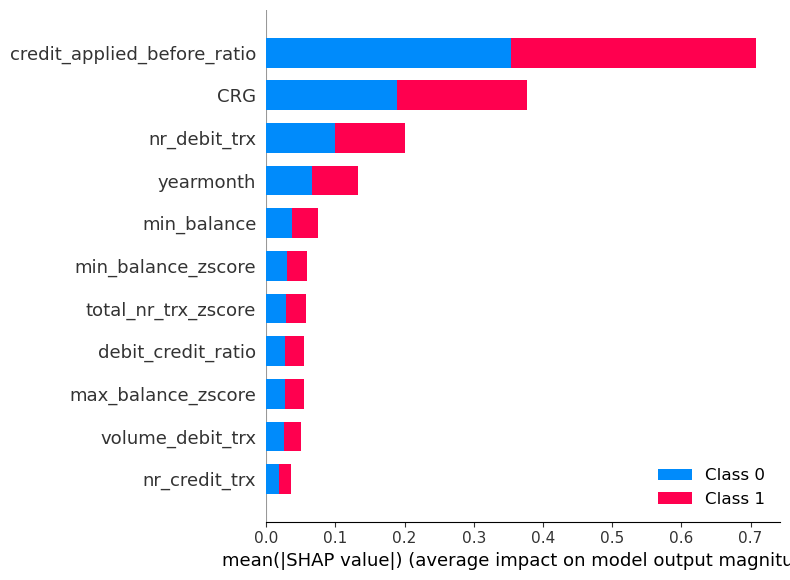

In [73]:
import shap
explainer = shap.TreeExplainer(model_new)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")

[[2108 1560]
 [  75  237]]
[0 0 0 ... 1 0 1]
[[1901 1766]
 [  77  235]]
[0 0 0 ... 0 1 1]
[[1970 1697]
 [  71  241]]
[0 0 0 ... 1 1 1]
[[1448 2219]
 [  62  250]]
[1 1 1 ... 1 1 0]
[[1510 2157]
 [  48  264]]
[0 0 0 ... 0 0 0]
ROC AUC=0.67
ROC AUC=0.64
ROC AUC=0.65
ROC AUC=0.60
ROC AUC=0.63
Mean ROC AUC score on validation data =0.64


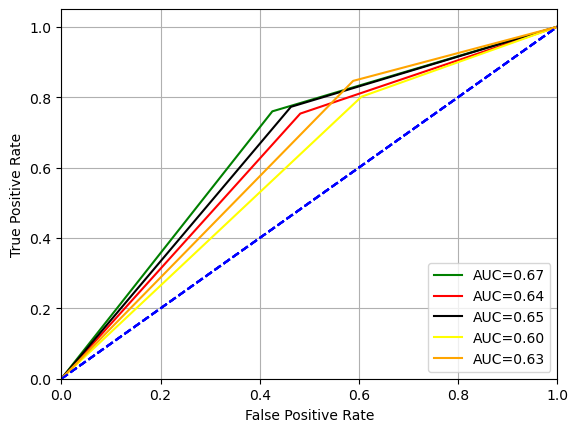

In [74]:
current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model_new,X_train_org[X_train.columns],y_train_org,0.4)
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [75]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model_new.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1665 2575]
 [  35  288]]
F1 score on Test data:
0.1807909604519774
-----------------------------------------------------
Recall score on Test data:
0.891640866873065
-----------------------------------------------------
Precision score on Test data:
0.10059378274537199
---------------THRESHOLD =0.35 ----------------------
[[2066 2174]
 [  52  271]]
F1 score on Test data:
0.1958092485549133
-----------------------------------------------------
Recall score on Test data:
0.8390092879256966
-----------------------------------------------------
Precision score on Test data:
0.11083844580777096
---------------THRESHOLD =0.4 ----------------------
[[2168 2072]
 [  56  267]]
F1 score on Test data:
0.20060105184072127
-----------------------------------------------------
Recall score on Test data:
0.826625386996904
-----------------------------------------------------
Precision score on Test data:
0.11415134672937152
---------------THRESHO

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [82]:
# X_test=X_test[X_train.columns]
y_test_pred=np.where(model_new.predict_proba(X_test[X_train.columns])[:,1] >0.46,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2302 1938]
 [  67  256]]
F1 score on Test data:
0.20341676599125946
-----------------------------------------------------
Recall score on Test data:
0.7925696594427245
-----------------------------------------------------
Precision score on Test data:
0.11668185961713765


In [ ]:
# 0.20677966101694914
# 0.7554179566563467
# 0.11978399607265587
# array([[2447, 1793],
#        [  79,  244]], dtype=int64)